# Fitting an Einsum Network (Einet) on Synthetic 2D Data

In this tutorial, we'll go through the steps of fitting an Einsum Network (Einet) with a multivariate normal distribution on synthetic 2D data. We'll start by generating synthetic data, then initialize and train our Einet model, and finally visualize the results.

For a fresh start, install the following libraries:

* torch
* matplotlib
* seaborn
* scipy
* tqdm

This can be done by running
```
pip install torch matplotlib seaborn scipy tqdm
```

In [1]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

torch.manual_seed(1)
np.random.seed(1)

sns.set_style("whitegrid")

## Generating Synthetic Data

Next, we define a function to generate our synthetic 2D data. This data will be created from multiple anisotropic Gaussian distributions to provide a mix of points.

In [2]:
def generate_data(num_samples=100):
    # Parameters for first Gaussian blob
    mean1 = [2.0, 3.0]
    cov1 = [[1.0, 0.3], [0.3, 0.5]]

    # Parameters for second Gaussian blob
    mean2 = [-1.0, -2.0]
    cov2 = [[0.4, -0.1], [-0.1, 0.3]]

    # Parameters for third Gaussian blob
    mean3 = [4.0, -1.0]
    cov3 = [[0.3, 0.2], [0.2, 0.5]]

    # Parameters for fourth Gaussian blob
    mean4 = [-3.0, 2.0]
    cov4 = [[0.5, -0.2], [-0.2, 0.3]]

    # Generate data points
    data1 = np.random.multivariate_normal(mean1, cov1, num_samples // 4)
    data2 = np.random.multivariate_normal(mean2, cov2, num_samples // 4)
    data3 = np.random.multivariate_normal(mean3, cov3, num_samples // 4)
    data4 = np.random.multivariate_normal(mean4, cov4, num_samples // 4)
    data = np.vstack([data1, data2, data3, data4])
    #data = (data - data.min()) / (data.max() - data.min()) * 10 - 5

    return torch.tensor(data, dtype=torch.float32)

In [3]:
def generate_uniform_data(num_samples=100):
    data = np.random.uniform(low=-5, high=5, size=(num_samples, 2))
    return torch.tensor(data, dtype=torch.float32)

## Data Visualization

Visualizing our synthetic data helps us understand its structure and distribution.

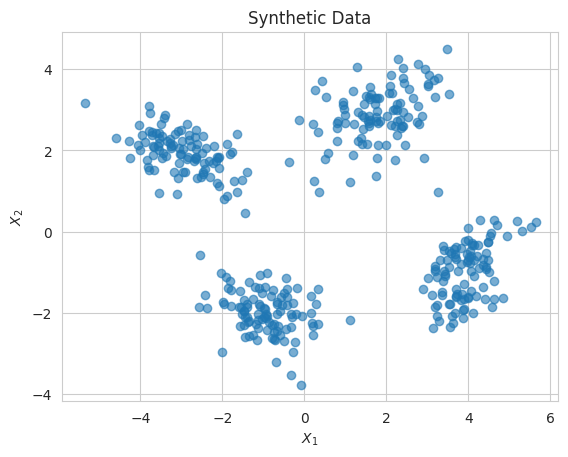

In [4]:
num_datasamples = 400
data = generate_data(num_datasamples)
plt.scatter(data[:, 0], data[:, 1], alpha=0.6)
plt.title("Synthetic Data")
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.show()

## Einet Model Initialization

We then proceed to configure and initialize our `Einet` model with the `EinetConfig` class.

In [5]:
from simple_einet.einet import Einet, EinetConfig
from simple_einet.layers.distributions.multivariate_normal import MultivariateNormal
from simple_einet.layers.distributions.normal import Normal

# The model will be trained to fit the synthetic data
cfg = EinetConfig(
    num_features=2,
    num_channels=1,
    num_leaves=4,
    depth=1,
    num_sums=4,
    num_repetitions=4,
    num_classes=1,
    leaf_type=Normal,
    #leaf_kwargs={"cardinality": cardinality},
    layer_type="einsum",
    dropout=0.0,
)
model = Einet(cfg)
print(model)

Einet(
  EinetConfig(num_features=2, num_channels=1, num_sums=4, num_leaves=4, num_repetitions=4, num_classes=1, depth=1, dropout=0.0, leaf_type=<class 'simple_einet.layers.distributions.normal.Normal'>, leaf_kwargs={}, layer_type='einsum')
  (leaf): FactorizedLeaf(
    num_features=2, num_features_out=2
    (base_leaf): Normal(num_features=2, num_leaves=4, out_shape=(N, 2, 4))
  )
  (layers): ModuleList(
    (0): EinsumLayer(num_features=2, num_sums_in=4, num_sums_out=1, out_shape=(N, 1, 1, 4), weight_shape=(1, 1, 4, 4, 4))
  )
  (mixing): MixingLayer(num_features=1, num_sums_in=4, num_sums_out=1)
)


## Training the Model

Using the Adam optimizer, we train our model on the synthetic data. We use the negative log-likelihood as our loss function, which is typical for probability density estimation tasks.

In [6]:
# Setup optimization
optimizer = optim.Adam(model.parameters(), lr=0.01)
epochs = 1000

# Training loop to fit the Multivariate Normal model
for epoch in range(epochs):
    optimizer.zero_grad()
    log_prob = model(data)

    # Negative log-likelihood as loss function
    loss = -torch.mean(log_prob)
    loss.backward()
    optimizer.step()

    # Logging to monitor progress
    if epoch % 100 == 99:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}")

Epoch [100/1000], Loss: 4.228370189666748
Epoch [200/1000], Loss: 3.628538131713867
Epoch [300/1000], Loss: 3.4621024131774902
Epoch [400/1000], Loss: 3.3290441036224365
Epoch [500/1000], Loss: 3.3113489151000977
Epoch [600/1000], Loss: 3.2894093990325928
Epoch [700/1000], Loss: 3.2786614894866943
Epoch [800/1000], Loss: 3.2599668502807617
Epoch [900/1000], Loss: 3.2280795574188232
Epoch [1000/1000], Loss: 3.222810983657837


## Results Visualization

After training, we sample from the model and visualize these samples alongside our original data. We use seaborn to create density plots that show the distribution learned by the model.

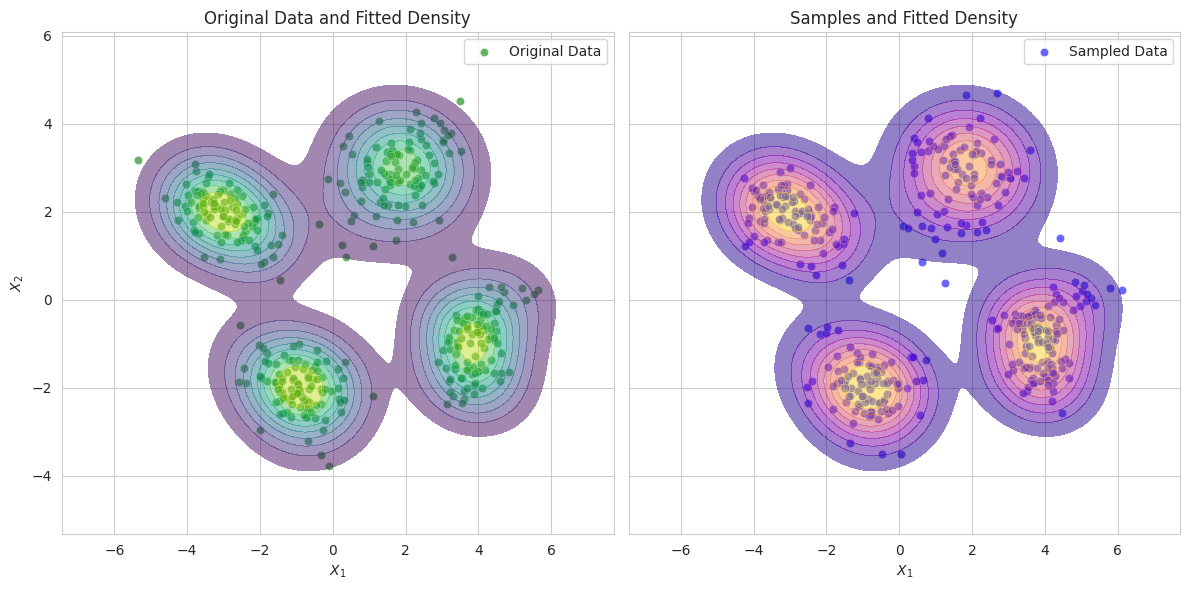

In [7]:
def plot_data_and_distribution_seaborn(data, samples, model):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

    # Generate a grid over which we evaluate the model's density function
    x, y = np.linspace(data[:, 0].min(), data[:, 0].max(), 100), np.linspace(
        data[:, 1].min(), data[:, 1].max(), 100
    )
    X, Y = np.meshgrid(x, y)
    grid = np.vstack([X.ravel(), Y.ravel()]).T

    # Evaluate the learned density function over the grid
    with torch.no_grad():
        grid_tensor = torch.tensor(grid, dtype=torch.float32)
        log_prob = model(grid_tensor)
        prob_density = log_prob.exp().numpy().ravel()  # Ensure this is 1-dimensional

    # Plot for original data points using Seaborn
    sns.scatterplot(x=data[:, 0], y=data[:, 1], ax=axes[0], color="green", alpha=0.6, label="Original Data")
    sns.kdeplot(x=grid[:, 0], y=grid[:, 1], weights=prob_density, fill=True, ax=axes[0], cmap="viridis", alpha=0.5)
    axes[0].set_title("Original Data and Fitted Density")
    axes[0].legend()
    axes[0].set_xlabel("$X_1$")
    axes[0].set_ylabel("$X_2$")

    # Plot for sampled data points using Seaborn
    sns.scatterplot(x=samples[:, 0], y=samples[:, 1], ax=axes[1], color="blue", alpha=0.6, label="Sampled Data")
    sns.kdeplot(x=grid[:, 0], y=grid[:, 1], weights=prob_density, fill=True, ax=axes[1], cmap="plasma", alpha=0.5)
    axes[1].set_title("Samples and Fitted Density")
    axes[1].legend()
    axes[1].set_xlabel("$X_1$")
    axes[1].set_ylabel("$X_2$")

    plt.tight_layout()
    plt.show()
    
# Sample
samples = model.sample(num_samples=num_datasamples)
samples.squeeze_(1)

plot_data_and_distribution_seaborn(data, samples, model)


In [8]:
from scipy.stats import multivariate_normal

def calc_cdf(x):
    # Parameters for first Gaussian blob
    mean1 = [2.0, 3.0]
    cov1 = [[1.0, 0.3], [0.3, 0.5]]

    # Parameters for second Gaussian blob
    mean2 = [-1.0, -2.0]
    cov2 = [[0.4, -0.1], [-0.1, 0.3]]

    # Parameters for third Gaussian blob
    mean3 = [4.0, -1.0]
    cov3 = [[0.3, 0.2], [0.2, 0.5]]

    # Parameters for fourth Gaussian blob
    mean4 = [-3.0, 2.0]
    cov4 = [[0.5, -0.2], [-0.2, 0.3]]

    cdf1 = multivariate_normal.cdf(x, mean=mean1, cov=cov1)
    cdf2 = multivariate_normal.cdf(x, mean=mean2, cov=cov2)
    cdf3 = multivariate_normal.cdf(x, mean=mean3, cov=cov3)
    cdf4 = multivariate_normal.cdf(x, mean=mean4, cov=cov4)

    cdf = (cdf1 + cdf2 + cdf3 + cdf4) / 4
    return cdf

In [9]:
def calc_integral(interval):
    assert(interval.dim() == 2), f"Wrong dimention of interval"
    ll, ur = interval.unbind(-1)
    lb1, lb2 = ll.tolist()
    ub1, ub2 = ur.tolist()
    res = calc_cdf([ub1, ub2]) - calc_cdf([lb1, ub2]) - calc_cdf([ub1, lb2]) + calc_cdf([lb1, lb2])
    return res

In [10]:
from tqdm import tqdm

def generate_query():
    l1, l2, u1, u2 = np.random.rand(4) * 8 - 4
    if l1 > u1:
        l1, u1 = u1, l1
    if l2 > u2:
        l2, u2 = u2, l2 
    return torch.Tensor([[[l1, u1], [l2, u2]]])

def get_samples(num_samples):
    samples = model.sample(num_samples=num_samples)
    samples.squeeze_(1)
    return samples

def calc_qerr(est, GT, epsilon = 0.001):
    if GT < epsilon:
        GT = epsilon
    if est < epsilon:
        est = epsilon
    return max(GT / est, est / GT)

def perform_query(points, query):
    ll, ur = query.squeeze().unbind(-1)
    l1, l2 = ll.tolist()
    u1, u2 = ur.tolist()
    cnt = 0
    for pt in points:
        if l1 <= pt[0] and pt[0] <= u1 and l2 <= pt[1] and pt[1] <= u2:
            cnt += 1
    if cnt < 10:
        cnt = 10
    return cnt

def experiment_integrate(n_runs, epsilon = 0.001):
    gmq = 0
    for i in tqdm(range(n_runs)):
        while True:
            query = generate_query()
            GT = calc_integral(query.squeeze())
            if (GT > epsilon):
                break
        est = model.integrate(query).item()
        q_err = calc_qerr(est, GT, epsilon)
        gmq += np.log(q_err)
    return np.exp(gmq / n_runs)

In [11]:
def experiment_counting(n_runs, epsilon = 0.001):
    gmq = 0
    for i in tqdm(range(n_runs)):
        while True:
            query = generate_query()
            GT = perform_query(data, query)
            if (GT > 10):
                break
        GT = GT / num_datasamples
        est = model.integrate(query).item()
        q_err = calc_qerr(est, GT, epsilon)
        gmq += np.log(q_err)
    return np.exp(gmq / n_runs)

In [12]:
experiment_integrate(1000, 10 / num_datasamples)

100%|██████████| 1000/1000 [00:03<00:00, 318.02it/s]


1.0980649994979959

In [13]:
experiment_counting(1000, 10 / num_datasamples)

100%|██████████| 1000/1000 [00:06<00:00, 155.64it/s]


1.0695913887367443